In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
import gc
import warnings
warnings.filterwarnings("ignore")

## Read Source Files

In [2]:
df_train=pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
df_train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df_train_orig=pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")
df_train_orig['id']=-9999
df_train_orig=df_train_orig[df_train.columns]
df_train_orig.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,-9999,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,-9999,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,-9999,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,-9999,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,-9999,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Merge Files

In [4]:
df_train['typ']=0
df_train_orig['typ']=0
df_test['typ']=1
#
df_all=pd.concat([df_train,df_train_orig,df_test],axis=0)

## Exploratory Data Analysis

In [5]:
cat_feats = df_all.columns[np.where(df_all.dtypes == "object")[0]].drop('NObeyesdad')
num_feats  = df_all.columns[np.where(df_all.dtypes != "object")[0]].drop(['id','typ'])
print("Categorical Features:",list(cat_feats))
print("Numerical Features:",list(num_feats))

Categorical Features: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numerical Features: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


### Target Distribution

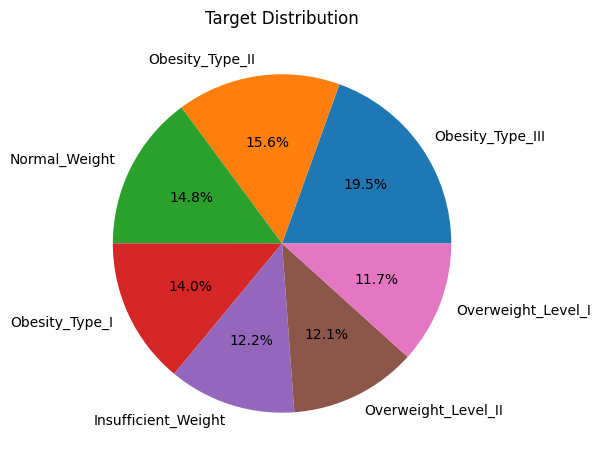

In [6]:
plt.subplots(figsize=(6,6))
temp = df_train['NObeyesdad'].value_counts()
plt.pie(temp.values, labels=temp.index.values,
            autopct='%1.1f%%')
plt.title("Target Distribution")
plt.tight_layout()
plt.show()

### Categorical Features Distribution

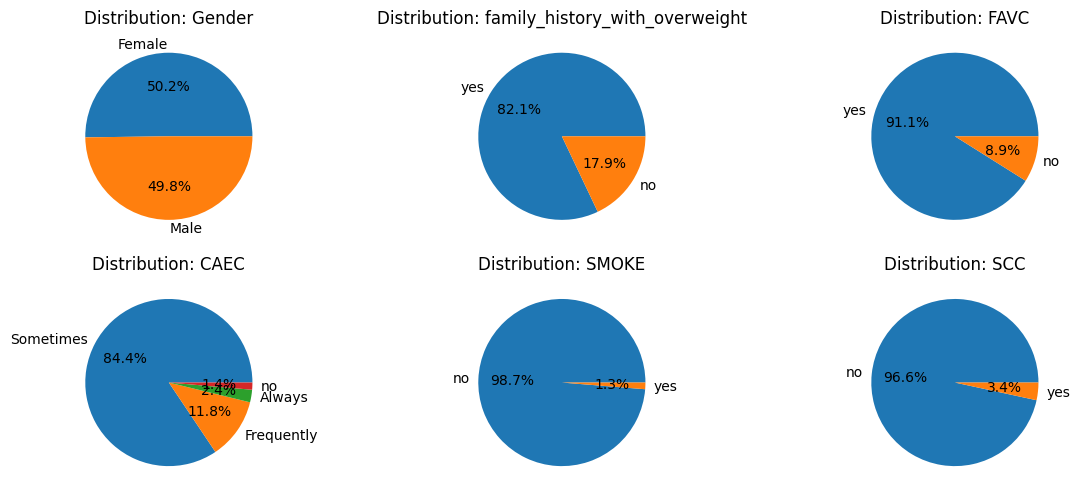

In [7]:
plt.subplots(figsize=(12, 10))
 
cat_feats_plot=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE','SCC']
for i, col in enumerate(cat_feats_plot):
    plt.subplot(4, 3, i+1)

    temp = df_all[col].value_counts()
    plt.pie(temp.values, labels=temp.index.values,
            autopct='%1.1f%%')
    plt.title("Distribution: "+str(col))
plt.tight_layout()
plt.show()

### Numerical Features Density Distribution

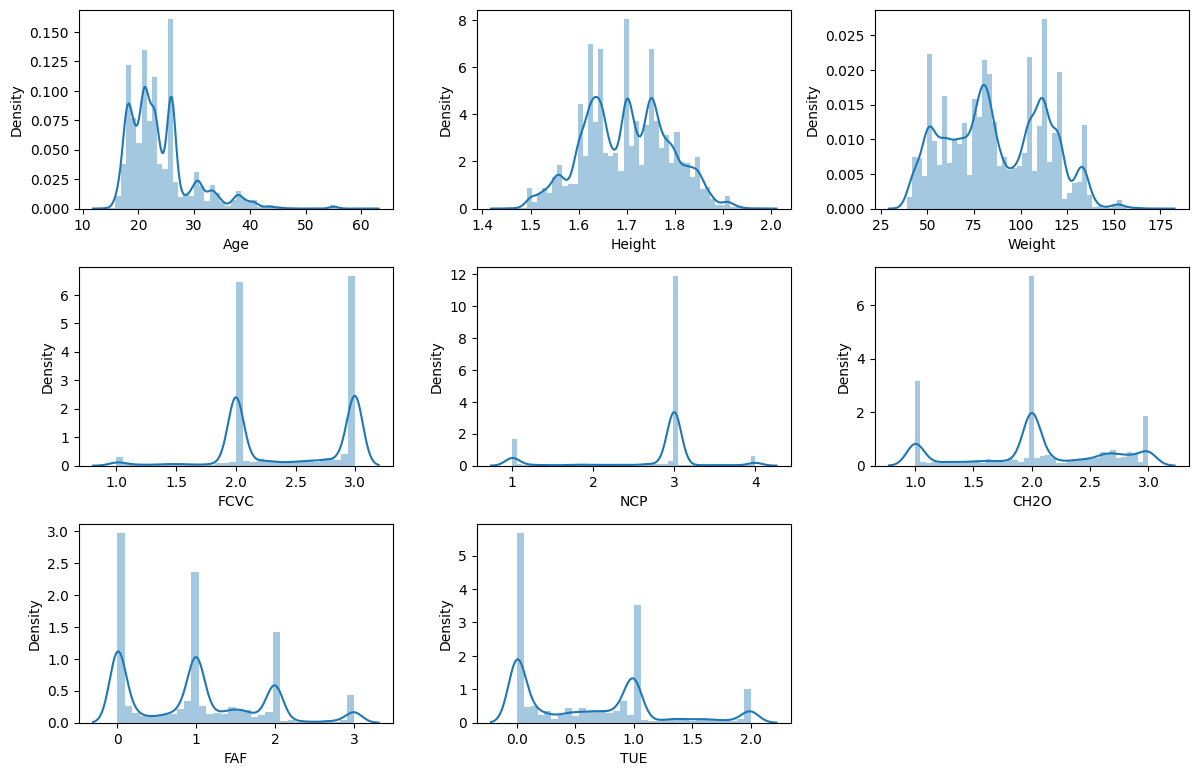

In [8]:
plt.subplots(figsize=(12,10))
 
for i, col in enumerate(num_feats):
    plt.subplot(4, 3, i+1)
    sb.distplot(df_all[col])
plt.tight_layout()
plt.show()

## Feature Engineering

In [9]:
df_all['BMI'] = (df_all['Weight']/df_all['Height']**2)
df_all=pd.get_dummies(df_all,columns=cat_feats)
sc=StandardScaler()
df_all[num_feats]=sc.fit_transform(df_all[num_feats])

In [10]:
df_train = df_all[df_all.typ==0].reset_index(drop=True)
df_test = df_all[df_all.typ==1].reset_index(drop=True)
##
print(len(df_train))
print(len(df_test))
##
feat_cols=df_train.columns.drop(['id','typ','NObeyesdad'])
X_test=df_test[feat_cols]
##
print(feat_cols)
df_train.head()

22869
13840
Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
       'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,0.092240,0.001869,-0.226623,-0.832095,0.323530,1.204387,-1.167749,0.594429,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False
1,1,-1.024227,-1.585157,-1.165740,-0.832095,0.346989,-0.047850,0.023019,0.633329,Normal_Weight,...,False,False,False,False,True,True,False,False,False,False
2,2,-1.024227,0.131803,-1.425901,-1.056375,-1.883722,-0.194827,-0.136490,1.747060,Insufficient_Weight,...,False,False,False,False,True,False,False,False,True,False
3,3,-0.512567,0.123528,1.661699,1.045255,0.346989,-0.582380,0.580135,0.269902,Obesity_Type_III,...,False,False,False,True,False,False,False,False,True,False
4,4,1.339547,2.429918,0.235061,0.443872,-1.097528,-0.080898,1.175650,0.520434,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False


In [11]:
X=df_train[feat_cols]
y=df_train['NObeyesdad']
#
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
del df_train,df_all
gc.collect()

21250

## Training and Validations

In [13]:
params = {
    "num_class": 7, "boosting_type": "gbdt",
    "objective": "multiclass","metric": "multi_logloss",
    'lambda_l1': 0.01,'lambda_l2': 0.04,
    "verbosity": -1,"random_state": 42,
    'learning_rate': 0.05,'n_estimators': 600,'max_depth': 10,  'colsample_bytree': 0.41,
    'subsample': 0.95,'min_child_samples': 25
}

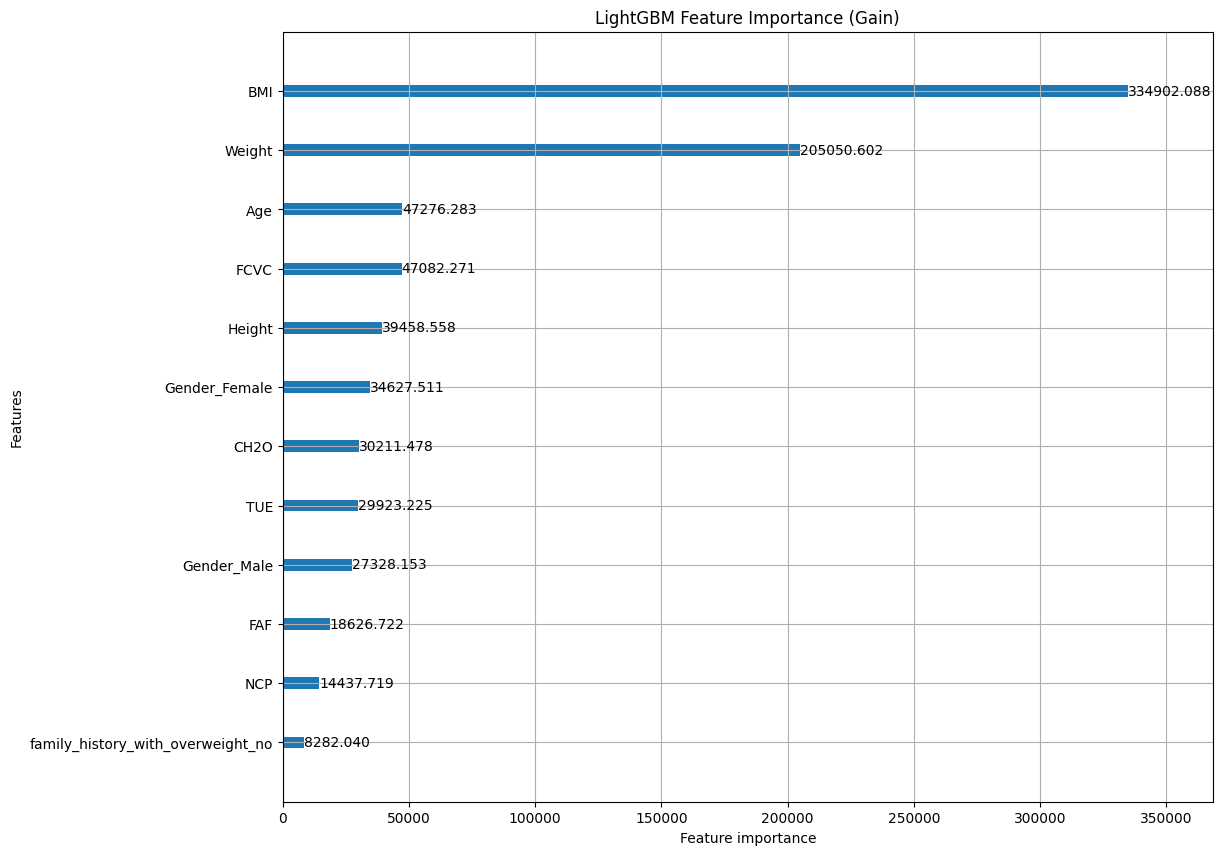

In [14]:
LGB=lgb.LGBMClassifier(**params)
LGB.fit(X,y)
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,10), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

## Prediction and Submission

### Define thresholds

In [15]:
def apply_thresholds(y_proba, thresholds):
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

thresh = {'threshold_0': 0.72, 'threshold_1': 0.62, 
          'threshold_2': 0.29, 'threshold_3': 0.31, 
          'threshold_4': 0.85, 'threshold_5': 0.68, 
          'threshold_6': 0.36}

### Predict and Apply thresholds

In [16]:
y_test_proba=LGB.predict_proba(df_test[feat_cols])
y_test=apply_thresholds(y_test_proba, thresh)
y_test

array([3, 5, 4, ..., 0, 1, 3])

### Submission

In [17]:
y_test=label_encoder.inverse_transform(y_test)
submission = df_test[['id']]
submission['NObeyesdad']=y_test
submission.to_csv("submission.csv", index=False)
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
